In [88]:
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import StratifiedKFold

In [2]:
from pipelines import nested_cross_validate_score, pipeline_Donker
from transform import combine_tsv_files
from utils import get_sub_pipeline

In [3]:
# Difference genomic variable.
X, y = combine_tsv_files(
    "output/all__gene__up_or_down__No. Mutant Molecules per mL.tsv",
    "output/all__gene__up_or_down__CNV Score.tsv",
)

In [4]:
y['response_grouped'].unique()

array(['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)'],
      dtype=object)

In [5]:
p = pipeline_Donker(CategoricalNB())

In [6]:
s = nested_cross_validate_score(p, X, y['response_grouped'] == 'responder (pr+cr)', metric='roc_auc_ovr_weighted')

--------------------
CategoricalNB() :
params: {'estimator__alpha': [0.125, 0.25, 0.5, 1.0, 2.0]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.1s finished


In [7]:
s.mean()

0.6963760683760685

In [8]:
p.fit(X, y['response_grouped'])

Pipeline(steps=[('clinical_curation',
                 FunctionTransformer(func=<function clinical_data_curation at 0x7f11bbfacaf0>)),
                ('filter_clinical_variables',
                 FunctionTransformer(func=<function drop_specific_phenotypes at 0x7f11bbfaca60>)),
                ('discretise_genomics',
                 TransformColumnType(column_type='numeric',
                                     transformation=<function pipeline_Donker.<locals>.genomics_discretiser at 0x7f11bbfdf5e0>)),
                ('LabelEncoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('estimator', CategoricalNB())])

In [9]:
len(p.named_steps['estimator'].feature_log_prob_[1])

3

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, auc, accuracy_score
y_pred = cross_val_predict(p, X, y['response_grouped'], cv=10)
conf_mat = confusion_matrix(y['response_grouped'], y_pred)

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix, roc_curve
from utils import double_cross_validate

In [78]:
@double_cross_validate(5, 5)
def metrics(clf, X, y):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    # Make one v.s. rest classification.
    for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
        ybin_true = y == class_name
        ybin_pred = y_pred == class_name
        class_index = list(clf.classes_).index(class_name)
        y_prob = clf.predict_proba(X)[:, class_index]
        ybin_pred = clf.predict(X) == class_name
        fpr, tpr, _ = roc_curve(ybin_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        metrics.update({
            f'{class_name}__tprs': interp_tpr,
            f'{class_name}__fprs': mean_fpr,
            f'{class_name}__roc_auc': roc_auc_score(ybin_true, y_prob),
            f'{class_name}__accuracy': accuracy_score(ybin_true, ybin_pred),
            f'{class_name}__confusion_matrix': confusion_matrix(ybin_true, ybin_pred, normalize='true'),
        })
        print(class_name, roc_auc_score(ybin_true, y_prob))
    return metrics

In [79]:
p.fit(X, y['response_grouped'])
m_mean, m_std = metrics(p, X, y['response_grouped'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.8s finished
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non responder (sd+pd) 0.717391304347826
responder (pr+cr) 0.6367521367521367


<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non evaluable (ne) 0.7708333333333333
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non responder (sd+pd) 0.7717391304347826
responder (pr+cr) 0.7948717948717949


<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non evaluable (ne) 0.875
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.5s finished
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non responder (sd+pd) 0.677536231884058
responder (pr+cr) 0.6282051282051282


<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


non evaluable (ne) 0.6666666666666666
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.8s finished
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non responder (sd+pd) 0.6557971014492753
responder (pr+cr) 0.7649572649572649


<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non evaluable (ne) 0.5104166666666666
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non responder (sd+pd) 0.6742424242424242
responder (pr+cr) 0.6222222222222222


<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name
<ipython-input-78-21e1dfd8abf8>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ybin_pred = y_pred == class_name


non evaluable (ne) 0.8817204301075269


In [169]:
def confusion_matrix_plot(class_name, ax):
    label_abbrev = " ".join(class_name.split()[:-1]).replace('responder', "resp.").replace('evaluable', 'eval.')
    labels = ['rest', f'{label_abbrev}']
    confusion_matrix_mean = pd.DataFrame(m_mean[f'{class_name}__confusion_matrix'], index=labels, columns=labels)
    confusion_matrix_std = pd.DataFrame(m_std[f'{class_name}__confusion_matrix'], index=labels, columns=labels)
    c_annot = confusion_matrix_mean.applymap(lambda x: '{:0.2f} $\pm$'.format(x)) \
        + confusion_matrix_std.applymap(lambda x: '{:0.2f}'.format(x))
    sns.heatmap(
        confusion_matrix_mean,
        annot=c_annot,
        fmt='',
        cmap=plt.cm.Blues,
        ax=ax,
        cbar=False,
    )
#     ax.set_yticks(rotation=0)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    return ax

In [170]:
def plot_roc_curve(m_mean, m_std, class_name):
    plt.rc('font', family='serif')
    plt.figure(figsize=(4,3))
    fpr, tpr = m_mean[f'{class_name}__fprs'], m_mean[f'{class_name}__tprs']
    fpr_std, tpr_std = m_std[f'{class_name}__fprs'], m_std[f'{class_name}__tprs']
    tprs_upper = np.minimum(tpr + tpr_std, 1)
    tprs_lower = np.maximum(tpr - tpr_std, 0)

    fig, ax = plt.subplots()
    ax.set(
        xlim=[-0.05, 1.05], 
        ylim=[-0.05, 1.05],
        title=f"Receiver operating characteristic {class_name}",
    )
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Random', alpha=.8)
    mean_label = r'Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})'.format(
        m_mean[f'{class_name}__roc_auc'], 
        m_std[f'{class_name}__roc_auc'],
    )
    print(m_mean[f'{class_name}__accuracy'], )
    ax.plot(
        fpr, 
        tpr, 
        label=mean_label,
        lw=2,
    )
    ax.fill_between(fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                    label=r'$\pm$ 1 std. dev.')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(frameon=False, loc=2)
    inset_ax = ax.inset_axes([0.6, 0.15, 0.4, 0.4])
    confusion_matrix_plot(class_name, inset_ax)

0.7070588235294117
0.746890756302521
0.9137815126050419


<Figure size 288x216 with 0 Axes>

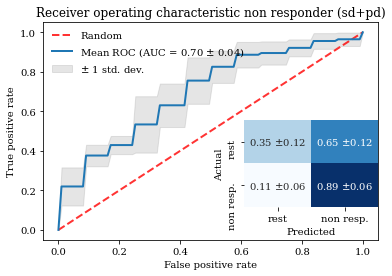

<Figure size 288x216 with 0 Axes>

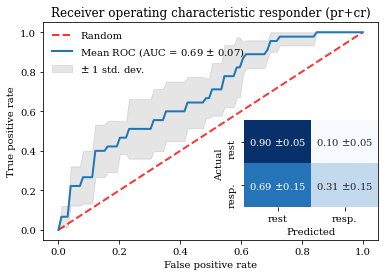

<Figure size 288x216 with 0 Axes>

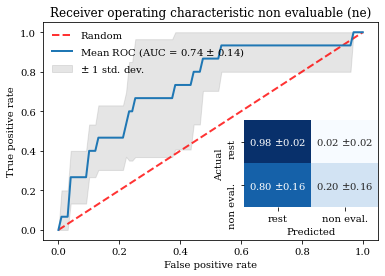

In [171]:
for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
    plot_roc_curve(m_mean, m_std, class_name)